<a href="https://colab.research.google.com/github/aqilyas/ThesisMI/blob/master/NN_RS_%26_IG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the process of model building after all processing is done. 
The first Part uses variables with embeddings, and Part 2 uses a dataset with numerical variables (as described in the results chapter)

##Packages

In [0]:
%tensorflow_version 1.x
import pandas as pd
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras import layers
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import tensorflow_hub as hub
import shutil

In [0]:
#from google.colab import files
#uploaded = files.upload()

## Loading data

In [0]:
!wget https://www.dropbox.com/s/1tz9p2tuiloni7k/data.csv?dl=1 -O data.csv

#**Part I**

In [0]:
df_1 = pd.read_csv('data.csv', index_col= 0)
#df_1.next_id = df_1.next_id.astype('category').cat.codes.values
df_1.head(3)

,userId,movieId,genres,original_title,duration,vote_average,title_year,director_name,actor_1_name,actor_2_name,next_id
1,1,1061,Crime Drama Thriller,Sleepers,147,73,23,Barry Levinson,Brad Pitt,Kevin Bacon,1129
2,1,1129,Science Fiction Action,Escape from New York,99,69,38,John Carpenter,Lee Van Cleef,Ernest Borgnine,1263
3,1,1263,Drama War,The Deer Hunter,183,78,41,Michael Cimino,John Cazale,John Savage,1293


In [0]:
len(df_1.next_id.unique())
len(df_1.movieId.unique())

3374

In [0]:
for column in df_1.columns:
  if df_1[column].dtype == object:
    df_1[column] = df_1[column].fillna('')
    
#df_1 = df_1.to_string()


##**Descriptives**

###Numeric Variables

In [0]:
df_1.describe()

,userId,movieId,duration,vote_average,title_year,next_id
count,66015.000000,66015.000000,66015.000000,66015.000000,66015.000000,66015.000000
mean,341.835977,13792.853261,119.153208,69.435128,23.848580,14192.434432
std,195.089253,27178.789566,24.247934,7.971788,12.252165,27687.326522
min,1.000000,10.000000,25.000000,0.000000,3.000000,11.000000
25%,174.000000,1095.000000,101.000000,64.000000,17.000000,1136.000000
50%,355.000000,2571.000000,116.000000,70.000000,22.000000,2628.000000
75%,514.000000,5956.000000,131.000000,75.000000,27.000000,6016.000000
max,671.000000,160438.000000,254.000000,100.000000,92.000000,160563.000000


###*Duration*

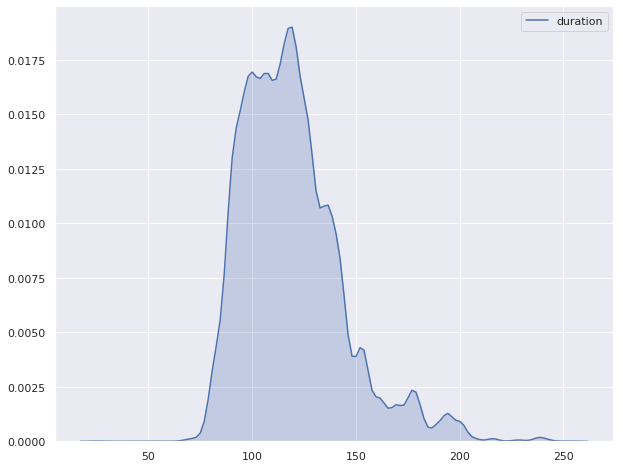

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline

#sns.set() #(style="whitegrid")
#plt.figure(figsize=(10,8))
#ax = sns.boxplot(x='duration', data=df_1, orient="v")
###########

sns.set()
plt.figure(figsize=(10,8))
sns.kdeplot(df_1['duration'], shade=True)
#sns.plt.show()
plt.savefig("density_2.png", bbox_inches = "tight")
files.download("density_2.png")

###*Vote Average*

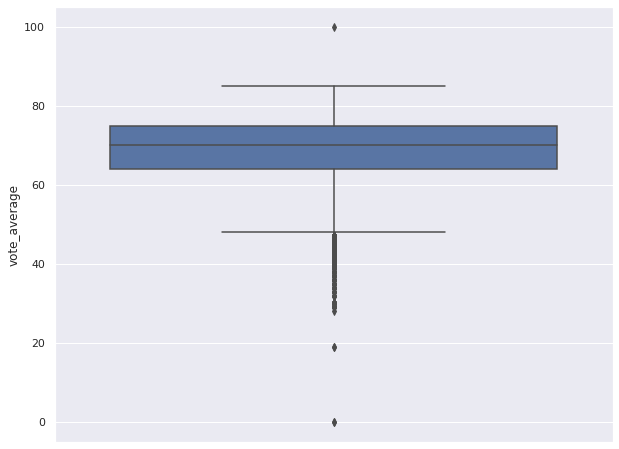

In [0]:
sns.set() #(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='vote_average', data=df_1, orient="v")



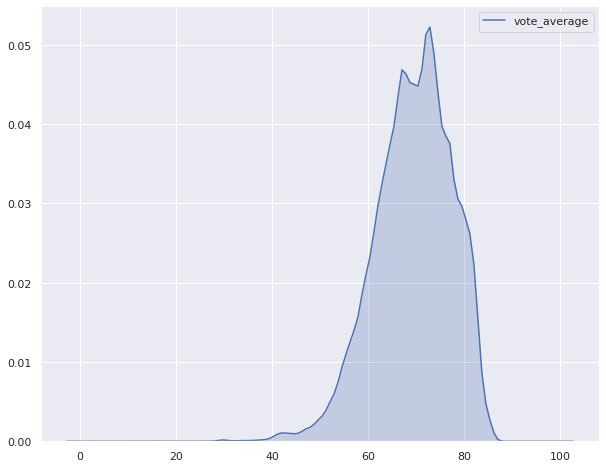

In [0]:
from google.colab import files
# density plot with shade
sns.set()
plt.figure(figsize=(10,8))
sns.kdeplot(df_1['vote_average'], shade=True)
#sns.plt.show()
plt.savefig("density_1.png", bbox_inches = "tight")
files.download("density_1.png")

###*Newness*

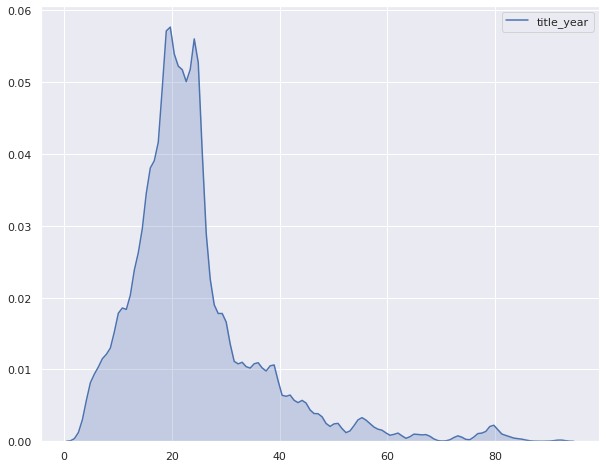

In [0]:
sns.set()
plt.figure(figsize=(10,8))
sns.kdeplot(df_1['title_year'], shade=True)
#sns.plt.show()
plt.savefig("density_new.png", bbox_inches = "tight")
files.download("density_new.png")

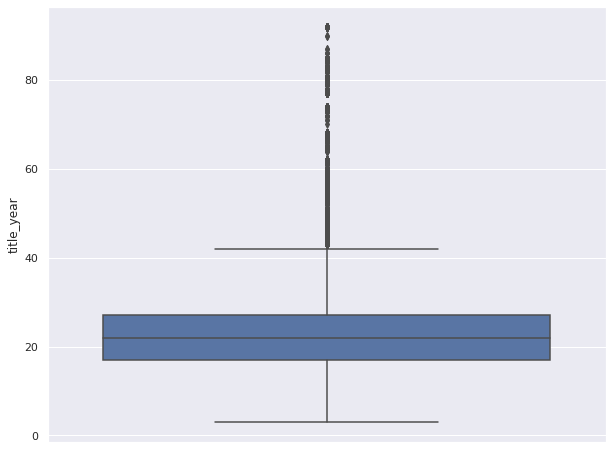

In [0]:
sns.set() #(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='title_year', data=df_1, orient="v")

###*Director*

In [0]:
directors_list = df_1.director_name.unique().tolist()
len(directors_list)

1481

###*First and second actor*

In [0]:
#Creating 1st actors list
actor_1_list = df_1.actor_1_name.unique().tolist()
print(len(actor_1_list))

#Creating 2nd actors list
actor_2_list = df_1.actor_2_name.unique().tolist()
print(len(actor_2_list))

1861
2181


##Creating lists to use later in feature_columns embeddings

In [0]:
#I get an error when I keep them as int
df_1['movieId'] = df_1['movieId'].astype(str)
df_1['userId'] = df_1['userId'].astype(str)
#type(df_1['movieId'])
df_1.dtypes

userId            object
movieId           object
genres            object
original_title    object
duration           int64
vote_average       int64
title_year         int64
director_name     object
actor_1_name      object
actor_2_name      object
next_id            int64
dtype: object

In [0]:

#list of 'next_id' movies Ids
nmovie_ids_list= df_1.next_id.unique().tolist()
len(nmovie_ids_list)

#list of movieIds
movieslist = df_1.movieId.unique().tolist()
#write_list_to_disk(movie_ids_list, "movieIdslist.txt")
userslist = df_1.userId.unique().tolist()


In [0]:
df_1.next_id = df_1.next_id.astype('category').cat.codes.values

In [0]:
#Creating directors list
directors_list = df_1.director_name.unique().tolist()
print(directors_list[:10])
len(directors_list)

#Creating 1st actors list
actor_1_list = df_1.actor_1_name.unique().tolist()
print(actor_1_list[:5])
len(actor_1_list)

#Creating 2nd actors list
actor_2_list = df_1.actor_2_name.unique().tolist()
print(actor_2_list[:5])
len(actor_2_list)

#Doing the same for Genres

genre_combi_list = df_1.genres.unique().tolist()
print(genre_combi_list[:6])
len(genre_combi_list)


['Barry Levinson', 'John Carpenter', 'Michael Cimino', 'Richard Attenborough', 'Francis Ford Coppola', 'Martin Scorsese', 'Robert Wise', 'Mike Judge', 'William Friedkin', 'Eric Darnell']
['Brad Pitt', 'Lee Van Cleef', 'John Cazale', 'Candice Bergen', 'Winona Ryder']
['Kevin Bacon', 'Ernest Borgnine', 'John Savage', 'Edward Fox', 'Anthony Hopkins']
['Crime Drama Thriller', 'Science Fiction Action', 'Drama War', 'Drama History', 'Romance Horror', 'Crime Thriller']


969

## Input Pipeline, from dataframe to tf dataset

We will change the pandas dataframe fromat to tf.data to suit the input features of the model by using embeddings

In [0]:
def df_to_dataset(dataframe, shuffle=True, batch_size=128):
  dataframe = dataframe.copy()
  labels = dataframe.pop('next_id')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

###Train Test sets

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_1, test_size=0.2)

In [0]:
batch_size = 128
train_ds = df_to_dataset(train, shuffle=False)
#val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [0]:
print(len(directors_list))
print(len(actor_1_list))
print(len(actor_2_list))
print(len(genre_combi_list))
print(len(nmovie_ids_list))
print(len(movieslist))

1481
1861
2181
969
3378
3374


##Feature Columns (Embeddings)

Feature Column is a powerful tensorFlow method to map the dataframe columns with the features in the tranining model. Besides, input columns we have are heterogeneous (text, categories, numbers), with embeddings we can create a layer to represent there columns in a much lower dimension space. 

In [0]:
#Title
#embedded_title_column = hub.text_embedding_column(key="original_title",
#                                                  module_spec = "https://tfhub.dev/google/random-nnlm-en-dim50/1")

#userId
user_id_column = feature_column.categorical_column_with_hash_bucket(key = "userId",
                                                                        hash_bucket_size = len(userslist)+1)
embedded_user_column = feature_column.embedding_column(categorical_column= user_id_column,
                                                             dimension = 10)

#movie_id
movie_id_column = feature_column.categorical_column_with_hash_bucket(key = "movieId",
                                                                        hash_bucket_size = len(movieslist)+1)
embedded_content_column = feature_column.embedding_column(categorical_column= movie_id_column,
                                                             dimension = 10)

#movie_id_column = feature_column.categorical_column_with_vocabulary_list(key = "movieId",
#                                                                        vocabulary_list = movieslist,
#                                                                         num_oov_buckets = 1)
#embedded_movie_column = feature_column.embedding_column(categorical_column= movie_id_column,
#                                                            dimension = 8)
#Director
director_column = feature_column.categorical_column_with_hash_bucket(key = "director_name",
                                                                        hash_bucket_size = len(directors_list)+1)
embedded_director_column = feature_column.embedding_column(categorical_column= director_column,
                                                              dimension = 8)
#Actor_1
actor_1_column = feature_column.categorical_column_with_hash_bucket(key = "actor_1_name",
                                                                        hash_bucket_size = len(actor_1_list)+1)
embedded_actor_1_column = feature_column.embedding_column(categorical_column= actor_1_column,
                                                              dimension = 8)
#Actor_2
actor_2_column = feature_column.categorical_column_with_hash_bucket(key = "actor_2_name",
                                                                        hash_bucket_size = len(actor_2_list)+1)
embedded_actor_2_column = feature_column.embedding_column(categorical_column= actor_2_column,
                                                              dimension = 8)
#Genres
#genre_column_categorical = feature_column.categorical_column_with_vocabulary_list(key = "genres",
#                                                                                     vocabulary_list = genre_combi_list,
#                                                                                     num_oov_buckets = 1)
#genre_column = feature_column.embedding_column(categorical_column= genre_column_categorical, 
#                                                  dimension = 8)
#Duration, bucketized
duration_column = feature_column.numeric_column(key = "duration")
duration_bucketized = feature_column.bucketized_column(source_column= duration_column,
                                                          boundaries = [80, 100, 130, 145, 170])
#Vote average bucketized
vote_column = feature_column.numeric_column(key = "vote_average")
vote_bucketized = feature_column.bucketized_column(source_column= vote_column,
                                                      boundaries = [50, 60, 70, 77, 81])
#year/niewness 
year_column = feature_column.numeric_column(key = "title_year")
year_bucketized = feature_column.bucketized_column(source_column= year_column,
                                                      boundaries = [10, 20, 25, 40])
                                                  
                                               
feature_columns = [embedded_user_column,
                   embedded_content_column,
                   #genre_column,
                   #embedded_title_column,
                   duration_bucketized,
                   vote_bucketized,
                   year_bucketized,
                   embedded_director_column,
                   embedded_actor_1_column,
                   embedded_actor_2_column]
 

##Layers + Model

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)



In [0]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(200, activation='relu'),
  #layers.Dropout(0.2),
  layers.Dense(100, activation='relu'),
  #layers.Dropout(0.2),
  layers.Dense(200, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(len(nmovie_ids_list), activation = 'softmax')  #added by me
])

# logit = tf.layers.dense(net, params['n_classes'], activation = None)



In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [0]:
hist = model.fit(train_ds, validation_data = test_ds, epochs = 70)

#  

Train on 413 steps, validate on 104 steps
Epoch 1/70
413/413 [==============================] - 9s 23ms/step - loss: 3.9419 - acc: 0.2498 - val_loss: 3.8679 - val_acc: 0.2673
Epoch 2/70
413/413 [==============================] - 8s 19ms/step - loss: 3.2056 - acc: 0.2984 - val_loss: 3.5972 - val_acc: 0.2856
Epoch 3/70
413/413 [==============================] - 9s 21ms/step - loss: 2.8443 - acc: 0.3247 - val_loss: 3.4994 - val_acc: 0.2926
Epoch 4/70
413/413 [==============================] - 8s 20ms/step - loss: 2.6025 - acc: 0.3438 - val_loss: 3.5015 - val_acc: 0.2968
Epoch 5/70
413/413 [==============================] - 8s 19ms/step - loss: 2.4332 - acc: 0.3617 - val_loss: 3.5537 - val_acc: 0.2943
Epoch 6/70
413/413 [==============================] - 8s 19ms/step - loss: 2.2910 - acc: 0.3762 - val_loss: 3.6783 - val_acc: 0.2927
Epoch 7/70
413/413 [==============================] - 8s 20ms/step - loss: 2.1815 - acc: 0.3942 - val_loss: 3.8189 - val_acc: 0.2904
Epoch 8/70
413/413 [=======

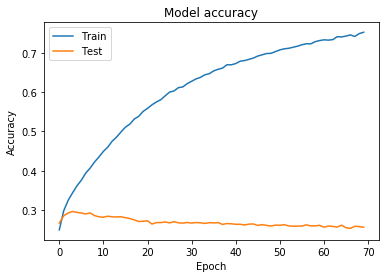

In [0]:
#viz
# Plot training & validation accuracy values
from google.colab import files
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig("acc.png") #, bbox_inches = "tight")
files.download("acc.png")

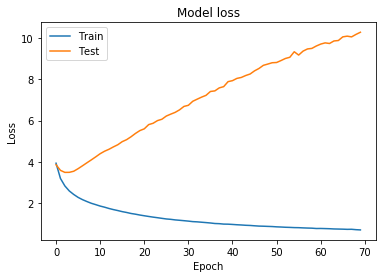

In [0]:
#plotting loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig("loss.png") #, bbox_inches = "tight")
files.download("loss.png")

In [0]:
#For later
from IntegratedGradients import *

The desired process was to be able to use Integrated Gradients on this neural network to try to get some explanations for a given prediction. Unfortunately I couldn't find an implementation that takes into account the heteregeneity of inputs. The next part is another attempt to use IG with a network with homogeneous inputs (numeric).

#**Part II**

Another experiment with Numerical features

removing all string variables (cast, title) 

**transforming the 'genres' feature to dummies** 

In [0]:
df_2 = pd.read_csv('data.csv', index_col= 0)
df_2.next_id = df_2.next_id.astype('category').cat.codes.values

In [0]:
d = {1: 'yes', 0: 'no'}
df_2 = df_2.join(df_2.pop('genres').str.get_dummies(' ').applymap(d.get))
#df_2.head()

In [0]:
df_2.head()

,userId,movieId,original_title,duration,vote_average,title_year,director_name,actor_1_name,actor_2_name,next_id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Fiction,Foreign,History,Horror,Movie,Music,Mystery,Romance,Science,TV,Thriller,War,Western
1,1,1061,Sleepers,147,73,23,Barry Levinson,Brad Pitt,Kevin Bacon,271,no,no,no,no,yes,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no
2,1,1129,Escape from New York,99,69,38,John Carpenter,Lee Van Cleef,Ernest Borgnine,312,yes,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,yes,no,no,no,no
3,1,1263,The Deer Hunter,183,78,41,Michael Cimino,John Cazale,John Savage,324,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no
4,1,1293,Gandhi,191,74,37,Richard Attenborough,Candice Bergen,Edward Fox,330,no,no,no,no,no,no,yes,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no
5,1,1339,Dracula,128,71,27,Francis Ford Coppola,Winona Ryder,Anthony Hopkins,331,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,yes,no,no,no,no,no


In [0]:
df_2 = df_2.drop(['original_title', 'director_name', 'actor_1_name', 'actor_2_name'], axis =1)

In [0]:
#not necessary, but when I used category_column_with_vocabulary_list('yes', 'no') it didn't work
colname = df_2.columns[6:]
print(colname)
for col in colname:
  df_2[col].replace(('yes', 'no'), (1,0), inplace = True)



Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Fiction', 'Foreign', 'History', 'Horror',
       'Movie', 'Music', 'Mystery', 'Romance', 'Science', 'TV', 'Thriller',
       'War', 'Western'],
      dtype='object')


In [0]:
df_2.head()

,userId,movieId,duration,vote_average,title_year,next_id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Fiction,Foreign,History,Horror,Movie,Music,Mystery,Romance,Science,TV,Thriller,War,Western
1,1,1061,147,73,23,1129,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1129,99,69,38,1263,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1263,183,78,41,1293,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,1293,191,74,37,1339,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,1,1339,128,71,27,1343,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [0]:
import numpy as np
colname = df_2.columns[6:]
genre = []
for col in colname:
  s = df_2[col].sum()
  genre.append(s)

bar_genre = {'name':colname, 'count':genre}
bargenre_df = pd.DataFrame(bar_genre)
bargenre_df

In [0]:
 
 import matplotlib.pyplot as plt
 import seaborn as sns
 plt.figure(figsize=(10,8))
 sns.set()
 ax = sns.barplot(x="name", y="count", data=bargenre_df,
                      palette="Blues_d")
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
 plt.savefig("genres.png", bbox_inches = "tight")
 files.download("genres.png")

###Transforming from df to dataset and creating train test

In [0]:
def df_to_dataset(dataframe, shuffle=True, batch_size=128):
  dataframe = dataframe.copy()
  labels = dataframe.pop('next_id')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
df_2.userId = df_2.userId.astype('category').cat.codes.values
df_2.movieId = df_2.movieId.astype('category').cat.codes.values

In [0]:
df_2.shape

(66015, 28)

In [0]:
#df_2['movieId'] = df_2['movieId'].astype(str)
#df_2['userId'] = df_2['userId'].astype(str)
#type(df_1['movieId'])
#df_2.dtypes

userId          object
movieId         object
duration         int64
vote_average     int64
title_year       int64
next_id          int16
Action           int64
Adventure        int64
Animation        int64
Comedy           int64
Crime            int64
Documentary      int64
Drama            int64
Family           int64
Fantasy          int64
Fiction          int64
Foreign          int64
History          int64
Horror           int64
Movie            int64
Music            int64
Mystery          int64
Romance          int64
Science          int64
TV               int64
Thriller         int64
War              int64
Western          int64
dtype: object

In [0]:
#list of 'next_id' movies Ids
nmovie_ids_list= df_2.next_id.unique().tolist()
len(nmovie_ids_list)

#list of movieIds
movieslist = df_2.movieId.unique().tolist()
#write_list_to_disk(movie_ids_list, "movieIdslist.txt")
userslist = df_2.userId.unique().tolist()
type(movieslist[1])

int

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_2, test_size=0.2)
test.head(3)

,userId,movieId,duration,vote_average,title_year,next_id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Fiction,Foreign,History,Horror,Movie,Music,Mystery,Romance,Science,TV,Thriller,War,Western
14964,151,663,122,68,21,673,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
29346,308,308,161,77,62,308,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
24776,261,976,102,73,19,976,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
batch_size = 128
train_ds = df_to_dataset(train, batch_size=batch_size)
#val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [0]:
train_ds.shape

### Preparing features

In [0]:
feature_columns = []

colname = df_2.columns[6:]

for col in colname:
  feature_columns.append(feature_column.numeric_column(col))
  #feature_columns.append(feature_column.embedding_column(category_column, dimension = 2))  #this seems useless to embed, but it gives me an error if I don't

#UserId
user_id_column = feature_column.categorical_column_with_hash_bucket(key = "userId",
                                                                        hash_bucket_size = len(userslist)+1)
feature_columns.append(feature_column.embedding_column(categorical_column= user_id_column,
                                                             dimension = 10))

#movie_id
movie_id_column = feature_column.categorical_column_with_hash_bucket(key = "movieId",
                                                                        hash_bucket_size = len(movieslist)+1)
feature_columns.append(feature_column.embedding_column(categorical_column= movie_id_column,
                                                             dimension = 10))

#Duration, bucketized
duration_column = feature_column.numeric_column(key = "duration")
feature_columns.append(feature_column.bucketized_column(source_column= duration_column,
                                                          boundaries = [80, 100, 130, 145, 170]))
#Vote average bucketized
vote_column = feature_column.numeric_column(key = "vote_average")
feature_columns.append(feature_column.bucketized_column(source_column= vote_column,
                                                      boundaries = [50, 60, 70, 77, 81]))
#year/niewness 
year_column = feature_column.numeric_column(key = "title_year")
feature_columns.append(feature_column.bucketized_column(source_column= year_column,
                                                      boundaries = [10, 20, 25, 40]))



In [0]:
print(feature_columns)

[NumericColumn(key='Action', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Adventure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Animation', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Comedy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Crime', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Documentary', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Drama', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Family', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Fantasy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Fiction', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
#feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
type(feature_layer)

tensorflow.python.feature_column.dense_features.DenseFeatures

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)


model = tf.keras.Sequential([
#model = Sequential([
  feature_layer,
  layers.Dense(200, activation='relu'),
  layers.Dense(100, activation='relu'),
  layers.Dense(50, activation='relu'),
  layers.Dense(len(nmovie_ids_list), activation = 'softmax')  #added by me
])


### The neural network


In [0]:
#trying with no embeddings

model = Sequential()
model.add(Dense(200, activation= 'relu', input_dim = 27))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(len(nmovie_ids_list), activation = 'softmax'))

In [0]:
isinstance(model, Sequential)


True

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [0]:
x_train = df_2.drop(['next_id'], axis=1)
y_train = df_2['next_id']

In [0]:
#model.fit(train_ds, validation_data = test_ds, epochs = 10)
model.fit(x_train, y_train, epochs = 100, validation_split= 0.2, batch_size= 128)
#same accuracy problem, more epochs, better accu

##**Integrated Gradient**

In [0]:
##### from the repo: https://github.com/hiranumn/IntegratedGradients/blob/master/IntegratedGradients.py

from __future__ import division, print_function
import numpy as np
from time import sleep
import sys
import keras.backend as K

from keras.models import Model, Sequential

'''
Integrated gradients approximates Shapley values by integrating partial
gradients with respect to input features from reference input to the
actual input. The following class implements the paper "Axiomatic attribution
for deep neuron networks".
'''
class integrated_gradients:
    # model: Keras model that you wish to explain.
    # outchannels: In case the model are multi tasking, you can specify which output you want explain .
    def __init__(self, model, outchannels=[], verbose=1):
    
        #get backend info (either tensorflow or theano)
        self.backend = K.backend()
        
        #load model supports keras.Model and keras.Sequential
        if isinstance(model, Sequential):   # I changed it from 'Sequential' to tf.keras.Sequential
            self.model = model
        elif isinstance(model, Model):
            self.model = model
        else:
            print("Invalid input model")
            return -1
        
        #load input tensors
        self.input_tensors = []
        for i in self.model.inputs:
            self.input_tensors.append(i)
        # The learning phase flag is a bool tensor (0 = test, 1 = train)
        # to be passed as input to any Keras function that uses 
        # a different behavior at train time and test time.
        self.input_tensors.append(K.learning_phase())
        
        #If outputchanels are specified, use it.
        #Otherwise evalueate all outputs.
        self.outchannels = outchannels
        if len(self.outchannels) == 0: 
            if verbose: print("Evaluated output channel (0-based index): All")
            if K.backend() == "tensorflow":
                self.outchannels = range(self.model.output.shape[1]._value)
            elif K.backend() == "theano":
                self.outchannels = range(self.model.output._keras_shape[1])
        else:
            if verbose: 
                print("Evaluated output channels (0-based index):")
                print(','.join([str(i) for i in self.outchannels]))
                
        #Build gradient functions for desired output channels.
        self.get_gradients = {}
        if verbose: print("Building gradient functions")
        
        # Evaluate over all requested channels.
        for c in self.outchannels:
            # Get tensor that calculates gradient
            if K.backend() == "tensorflow":
                gradients = self.model.optimizer.get_gradients(self.model.output[:, c], self.model.input)
            if K.backend() == "theano":
                gradients = self.model.optimizer.get_gradients(self.model.output[:, c].sum(), self.model.input)
                
            # Build computational graph that computes the tensors given inputs
            self.get_gradients[c] = K.function(inputs=self.input_tensors, outputs=gradients)
            
            # This takes a lot of time for a big model with many tasks.
            # So lets print the progress.
            if verbose:
                sys.stdout.write('\r')
                sys.stdout.write("Progress: "+str(int((c+1)*1.0/len(self.outchannels)*1000)*1.0/10)+"%")
                sys.stdout.flush()
        # Done
        if verbose: print("\nDone.")
            
                
    '''
    Input: sample to explain, channel to explain
    Optional inputs:
        - reference: reference values (defaulted to 0s).
        - steps: # steps from reference values to the actual sample (defualted to 50).
    Output: list of numpy arrays to integrated over.
    '''
    def explain(self, sample, outc=0, reference=False, num_steps=50, verbose=0):
        
        # Each element for each input stream.
        samples = []
        numsteps = []
        step_sizes = []
        
        # If multiple inputs are present, feed them as list of np arrays. 
        if isinstance(sample, list):
            #If reference is present, reference and sample size need to be equal.
            if reference != False: 
                assert len(sample) == len(reference)
            for i in range(len(sample)):
                if reference == False:
                    _output = integrated_gradients.linearly_interpolate(sample[i], False, num_steps)
                else:
                    _output = integrated_gradients.linearly_interpolate(sample[i], reference[i], num_steps)
                samples.append(_output[0])
                numsteps.append(_output[1])
                step_sizes.append(_output[2])
        
        # Or you can feed just a single numpy arrray. 
        elif isinstance(sample, np.ndarray):
            _output = integrated_gradients.linearly_interpolate(sample, reference, num_steps)
            samples.append(_output[0])
            numsteps.append(_output[1])
            step_sizes.append(_output[2])
            
        # Desired channel must be in the list of outputchannels
        assert outc in self.outchannels
        if verbose: print("Explaning the "+str(self.outchannels[outc])+"th output.")
            
        # For tensorflow backend
        _input = []
        for s in samples:
            _input.append(s)
        _input.append(0)
        
        if K.backend() == "tensorflow": 
            gradients = self.get_gradients[outc](_input)
        elif K.backend() == "theano":
            gradients = self.get_gradients[outc](_input)
            if len(self.model.inputs) == 1:
                gradients = [gradients]
        
        explanation = []
        for i in range(len(gradients)):
            _temp = np.sum(gradients[i], axis=0)
            explanation.append(np.multiply(_temp, step_sizes[i]))
           
        # Format the return values according to the input sample.
        if isinstance(sample, list):
            return explanation
        elif isinstance(sample, np.ndarray):
            return explanation[0]
        return -1

    
    '''
    Input: numpy array of a sample
    Optional inputs:
        - reference: reference values (defaulted to 0s).
        - steps: # steps from reference values to the actual sample.
    Output: list of numpy arrays to integrate over.
    '''
    @staticmethod
    def linearly_interpolate(sample, reference=False, num_steps=50):
        # Use default reference values if reference is not specified
        if reference is False: reference = np.zeros(sample.shape);

        # Reference and sample shape needs to match exactly
        assert sample.shape == reference.shape

        # Calcuated stepwise difference from reference to the actual sample.
        ret = np.zeros(tuple([num_steps] +[i for i in sample.shape]))
        for s in range(num_steps):
            ret[s] = reference+(sample-reference)*(s*1.0/num_steps)

        return ret, num_steps, (sample-reference)*(1.0/num_steps)

In [0]:
ig = integrated_gradients(model)


Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [0]:
train = train.to_numpy(dtype=int)


In [0]:
tst = x_train.to_numpy(dtype=int)
type(tst)

numpy.ndarray

In [0]:
tst[5]

array([  0, 332, 128,  70,  28,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0])

In [0]:
out = ig.explain(tst[5], num_steps=1000)
out

array([ 0.00000000e+00, -2.14596835e-10,  3.79793619e-10, -6.60277122e-11,
       -1.39650192e-10,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  4.31736709e-11,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.19855885e-11,  0.00000000e+00,  0.00000000e+00])

In [0]:
out2 = out*10**9
out2

array([ 0.        , -0.21459683,  0.37979362, -0.06602771, -0.13965019,
        0.        ,  0.        ,  0.        , -0.        ,  0.04317367,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.01198559,
        0.        ,  0.        ])

In [0]:
tst[5]

array([  0, 332, 128,  70,  28,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0])

In [0]:
features = list(x_train.columns)
print(features)

['userId', 'movieId', 'duration', 'vote_average', 'title_year', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'Foreign', 'History', 'Horror', 'Movie', 'Music', 'Mystery', 'Romance', 'Science', 'TV', 'Thriller', 'War', 'Western']


In [0]:
plotdata['Features'] = features
plotdata.head()

,values,column,Features
0,0.000000,1,userId
1,-0.214597,2,movieId
2,0.379794,3,duration
3,-0.066028,4,vote_average
4,-0.139650,5,title_year


In [0]:
plotdata.to_csv('plotig.csv')

In [0]:
#plotdata
import altair as alt

alt.Chart(plotdata).mark_bar().encode(
    x="column:T",
    y="values:Q",
    color=alt.condition(
        alt.datum.nonfarm_change > 0,
        alt.value("steelblue"),  # The positive color
        alt.value("orange")  # The negative color
    )
).properties(width=600)


alt.Chart(...)